# Paper ST Sloping - 6 beats

## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix
from imblearn.metrics import classification_report_imbalanced
import random
import time

In [2]:
THREADS_TO_USE = 4

In [3]:
def parse_accuracy_per_class(conf_matrix, classes):
    acc_per_class = dict()
    for i, c in enumerate(classes):
        tn, fp, fn, tp = conf_matrix[i].ravel()
        acc_per_class[c] = (tp + tn) /(tp + tn + fp + fn)
    return acc_per_class

## Load dataset

In [4]:
data = pd.read_csv('../dataset/st_dataset_6beats.csv')
data = data.dropna()
data.head()

,id,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,...,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16,label
0,e0106,21.861233,21.421103,21.536569,6.108208,0.880920,1.079942,-0.914392,-1.844370,-1.138702,...,-0.068189,0.053454,-0.067161,0.067961,-0.093129,0.027961,-0.038417,-0.011442,0.005966,NSR
1,e0106,26.408089,27.988299,27.611772,7.776970,1.129695,1.195165,-0.806390,-1.774080,-1.792590,...,-0.031130,0.017521,-0.014034,0.023165,-0.043346,-0.016159,-0.012820,-0.007157,-0.012377,NSR
2,e0106,25.977641,26.935251,26.561891,7.477219,1.098311,1.176663,-0.849446,-1.805917,-1.623971,...,-0.025147,0.006059,-0.022267,0.043209,-0.061407,-0.003576,-0.026326,0.004760,-0.015544,NSR
3,e0106,25.189643,25.649484,25.620624,7.261496,1.066191,1.162694,-0.825414,-1.684836,-1.477246,...,-0.040045,0.024580,-0.029490,0.040770,-0.057996,-0.012361,-0.019814,0.007333,-0.030823,NSR
4,e0106,24.659920,24.559022,24.462891,6.972141,1.008067,1.143318,-0.881397,-1.797336,-1.316414,...,-0.064038,0.044904,-0.045340,0.042700,-0.063328,-0.010253,-0.004272,-0.024278,0.001717,NSR


In [5]:
data['label'].value_counts()

NSR    69911
ST-    14662
ST+     6585
Name: label, dtype: int64

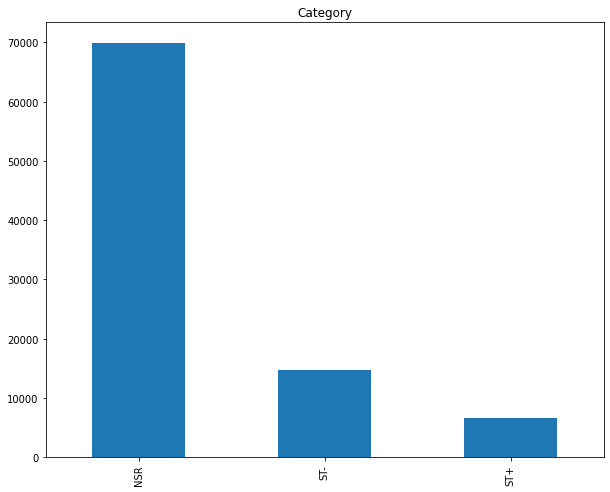

In [6]:
data['label'].value_counts().plot(kind='bar', title='Category', figsize=(10,8))
plt.show()

In [7]:
data.corr()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,mfw_5,...,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15,cfr_16
dw_1,1.000000,0.255941,0.126826,0.086712,0.088051,0.075713,-0.024569,0.012953,-0.001384,0.002394,...,-0.045708,-0.051747,-0.019303,-0.008486,-0.000878,-0.032264,-0.023128,-0.040651,-0.060588,-0.042833
dw_2,0.255941,1.000000,0.839774,0.443129,0.156197,0.418729,-0.461763,-0.218036,-0.003468,0.007413,...,-0.141060,0.127367,0.228143,0.164508,0.044436,0.028086,0.110780,-0.007514,-0.119066,-0.078764
dw_3,0.126826,0.839774,1.000000,0.617379,0.233068,0.346060,-0.532862,-0.300954,-0.002069,0.003404,...,-0.206438,0.110265,0.261460,0.116256,-0.047562,0.046009,0.046174,-0.030837,-0.133170,-0.047183
dw_4,0.086712,0.443129,0.617379,1.000000,0.899451,0.053813,-0.237258,-0.145344,-0.000228,0.000760,...,-0.142178,0.036774,0.117609,0.038427,-0.043639,0.039039,0.024440,-0.029533,-0.087767,-0.029773
dw_5,0.088051,0.156197,0.233068,0.899451,1.000000,-0.086599,-0.014596,-0.019561,0.000277,-0.000251,...,-0.064023,-0.004814,0.020295,0.008379,-0.014492,0.015851,0.009964,-0.028118,-0.040683,-0.015438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cfr_12,-0.032264,0.028086,0.046009,0.039039,0.015851,-0.077794,0.050496,0.076659,-0.000726,0.004327,...,-0.121386,-0.206635,-0.113087,0.008140,0.053560,1.000000,-0.006207,-0.033331,-0.303526,-0.194998
cfr_13,-0.023128,0.110780,0.046174,0.024440,0.009964,0.068140,0.004871,0.004627,0.000306,0.000798,...,0.120777,0.028507,-0.219328,-0.269074,-0.065839,-0.006207,1.000000,0.164767,0.075217,-0.175495
cfr_14,-0.040651,-0.007514,-0.030837,-0.029533,-0.028118,0.011829,0.019891,0.024541,0.001952,-0.001142,...,0.088392,0.207586,0.043674,-0.179302,-0.289882,-0.033331,0.164767,1.000000,0.131088,-0.151555
cfr_15,-0.060588,-0.119066,-0.133170,-0.087767,-0.040683,-0.021598,0.089608,0.046544,0.005107,-0.006644,...,0.251295,0.160789,-0.072934,-0.151000,-0.104688,-0.303526,0.075217,0.131088,1.000000,0.190121


In [8]:
y = data['label'].values
X = data.loc[:, ~data.columns.isin(["id", "label"])].copy()

In [9]:
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

## Feature selection

### Exclude features with corr > 0.95

In [10]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [11]:
print(correlated_features)

{'fft_187', 'fft_166', 'fft_247', 'fft_161', 'cfr_16', 'fft_169', 'fft_202', 'fft_192', 'fft_216', 'fft_131', 'fft_232', 'fft_248', 'fft_211', 'fft_139', 'fft_144', 'fft_188', 'fft_199', 'fft_254', 'fft_179', 'fft_149', 'mfw_16', 'fft_194', 'fft_212', 'fft_181', 'fft_229', 'fft_249', 'fft_171', 'fft_244', 'fft_186', 'fft_234', 'fft_206', 'fft_189', 'fft_228', 'fft_145', 'mfw_13', 'fft_147', 'fft_236', 'fft_185', 'fft_256', 'fft_143', 'fft_198', 'fft_237', 'fft_180', 'fft_222', 'fft_227', 'fft_233', 'fft_183', 'mfw_15', 'fft_173', 'fft_151', 'fft_241', 'mfw_7', 'fft_178', 'fft_197', 'fft_190', 'mfw_8', 'fft_255', 'fft_200', 'fft_203', 'fft_135', 'fft_164', 'fft_195', 'fft_163', 'fft_243', 'fft_168', 'fft_223', 'mfw_6', 'fft_165', 'fft_156', 'fft_152', 'fft_239', 'fft_142', 'fft_191', 'fft_253', 'fft_140', 'fft_217', 'fft_153', 'fft_158', 'fft_209', 'fft_224', 'fft_146', 'mfw_5', 'fft_133', 'fft_238', 'mfw_10', 'fft_137', 'fft_221', 'fft_204', 'fft_130', 'fft_218', 'mfw_11', 'fft_134', '

### Random forest embeded for features selection

In [12]:
cols_no_corr = [col for col in X.columns if col not in correlated_features]

In [13]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE), threshold='1.25*median')
embeded_rf_selector.fit(X[cols_no_corr], y)

SelectFromModel(estimator=RandomForestClassifier(n_jobs=4, random_state=101),
                threshold='1.25*median')

In [14]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X[cols_no_corr].loc[:,embeded_rf_support].columns.tolist()

print('\n'.join(embeded_rf_feature), '\nselected features:', len(embeded_rf_feature))

dw_1
dw_2
dw_3
dw_4
dw_5
mfw_1
mfw_2
mfw_3
mfw_4
fft_1
fft_2
fft_3
fft_4
fft_5
fft_6
fft_7
fft_8
fft_9
fft_10
fft_11
fft_12
fft_13
fft_14
fft_15
fft_16
fft_17
fft_18
fft_19
fft_20
fft_21
fft_22
fft_23
fft_24
fft_25
fft_26
fft_27
fft_28
fft_29
fft_30
fft_31
fft_32
fft_33
fft_34
fft_35
fft_36
fft_37
fft_38
ar_1
ar_2
ar_3
ar_4
ar_5
ar_6
ar_7
ar_8
ar_9
ar_10
ar_12
ar_16
var
cfr_1
cfr_2
cfr_3
cfr_4
cfr_5
cfr_6
cfr_7
cfr_8
cfr_9
cfr_10
cfr_11
cfr_12
cfr_13
cfr_14
cfr_15 
selected features: 75


### Visualization best features

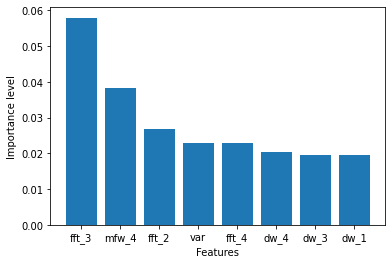

In [15]:
features_dict = dict(zip(cols_no_corr, embeded_rf_selector.estimator_.feature_importances_))
features_dict = dict(sorted(features_dict.items(), key=lambda item: item[1], reverse=True))

best_features = dict()
for index, (key, value) in enumerate(features_dict.items()):
    if index < 8:
        best_features[key] = value

plt.bar(range(len(best_features)), list(best_features.values()), align='center', )
plt.xticks(ticks=range(len(best_features)), labels=best_features.keys())
plt.xlabel('Features')
plt.ylabel('Importance level')
plt.show()

## Filter features

In [16]:
X_fsel = X[embeded_rf_feature]
X_fsel.head()

,dw_1,dw_2,dw_3,dw_4,dw_5,mfw_1,mfw_2,mfw_3,mfw_4,fft_1,...,cfr_6,cfr_7,cfr_8,cfr_9,cfr_10,cfr_11,cfr_12,cfr_13,cfr_14,cfr_15
0,21.861233,21.421103,21.536569,6.108208,0.880920,1.079942,-0.914392,-1.844370,-1.138702,-0.004752,...,0.006001,0.061446,-0.068189,0.053454,-0.067161,0.067961,-0.093129,0.027961,-0.038417,-0.011442
1,26.408089,27.988299,27.611772,7.776970,1.129695,1.195165,-0.806390,-1.774080,-1.792590,0.205786,...,0.027369,0.028651,-0.031130,0.017521,-0.014034,0.023165,-0.043346,-0.016159,-0.012820,-0.007157
2,25.977641,26.935251,26.561891,7.477219,1.098311,1.176663,-0.849446,-1.805917,-1.623971,-0.321053,...,0.008456,0.040828,-0.025147,0.006059,-0.022267,0.043209,-0.061407,-0.003576,-0.026326,0.004760
3,25.189643,25.649484,25.620624,7.261496,1.066191,1.162694,-0.825414,-1.684836,-1.477246,3.056053,...,0.029771,0.026605,-0.040045,0.024580,-0.029490,0.040770,-0.057996,-0.012361,-0.019814,0.007333
4,24.659920,24.559022,24.462891,6.972141,1.008067,1.143318,-0.881397,-1.797336,-1.316414,6.265323,...,-0.010154,0.059279,-0.064038,0.044904,-0.045340,0.042700,-0.063328,-0.010253,-0.004272,-0.024278


## Random Forest - 1000x random split

In [17]:
classes = np.unique(label_encoder.inverse_transform(y))

result_df = pd.DataFrame()

seeds = random.sample(range(1, 2**32 - 1), 1000)
for i, seed in enumerate(seeds):
    start_time = time.time()

    # Train and Test split
    x_train, x_test, y_train, y_test = train_test_split(X_fsel, y, test_size=0.2, random_state=seed)

    # Training
    model = RandomForestClassifier(random_state=101, n_jobs=THREADS_TO_USE).fit(x_train, y_train)

    # Prediction
    y_pred = model.predict(x_test)

    # Decode
    y_test_dec = label_encoder.inverse_transform(y_test)
    y_pred_dec = label_encoder.inverse_transform(y_pred)

    # get metrics
    report = classification_report_imbalanced(y_true=y_test_dec, y_pred=y_pred_dec, labels=label_encoder.classes_, zero_division=1, output_dict=True)
    confusion_matrix = multilabel_confusion_matrix(y_pred=y_pred_dec, y_true=y_test_dec, labels=classes)

    # TOTAL
    tot_accuracy    = accuracy_score(y_true=y_test_dec, y_pred=y_pred_dec)
    tot_precision   = report['avg_pre']
    tot_recall      = report['avg_rec']
    tot_specificity = report['avg_spe']
    tot_f1          = report['avg_f1']

    # NSR
    nsr_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['NSR']
    nsr_precision   = report['NSR']['pre']
    nsr_recall      = report['NSR']['rec']
    nsr_specificity = report['NSR']['spe']
    nsr_f1          = report['NSR']['f1']

    # ST+
    st1_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st1_precision   = report['ST+']['pre']
    st1_recall      = report['ST+']['rec']
    st1_specificity = report['ST+']['spe']
    st1_f1          = report['ST+']['f1']

    # ST-
    st0_accuracy    = parse_accuracy_per_class(confusion_matrix, classes)['ST+']
    st0_precision   = report['ST-']['pre']
    st0_recall      = report['ST-']['rec']
    st0_specificity = report['ST-']['spe']
    st0_f1          = report['ST-']['f1']

    # save result in result_df
    result_df = result_df.append({
        "accuracy": tot_accuracy,
        "precision": tot_precision,
        "recall": tot_recall,
        "specificity": tot_specificity,
        "f1": tot_f1,

        "nsr_accuracy": nsr_accuracy,
        "nsr_precision": nsr_precision,
        "nsr_recall": nsr_recall,
        "nsr_specificity": nsr_specificity,
        "nsr_f1": nsr_f1,

        "st+_accuracy": st1_accuracy,
        "st+_precision": st1_precision,
        "st+_recall": st1_recall,
        "st+_specificity": st1_specificity,
        "st+_f1": st1_f1,

        "st-_accuracy": st0_accuracy,
        "st-_precision": st0_precision,
        "st-_recall": st0_recall,
        "st-_specificity": st0_specificity,
        "st-_f1": st0_f1,
    }, ignore_index=True)
    end_time = time.time()

    elapsed_seconds = end_time - start_time
    # Log result
    print("#---------------------#")
    print(i+1, "of", len(seeds), "-", elapsed_seconds, "s")
    print("Tot: Accuracy", tot_accuracy, "Precision", tot_precision, "Recall", tot_recall, "Specificity", tot_specificity, "F1", tot_f1)
    print("NSR: Accuracy", nsr_accuracy, "Precision", nsr_precision, "Recall", nsr_recall, "Specificity", nsr_specificity, "F1", nsr_f1)
    print("ST+: Accuracy", st1_accuracy, "Precision", st1_precision, "Recall", st1_recall, "Specificity", st1_specificity, "F1", st1_f1)
    print("ST-: Accuracy", st0_accuracy, "precision", st0_precision, "Recall", st0_recall, "Specificity", st0_specificity, "F1", st0_f1)
    print("#---------------------#")

#---------------------#
1 of 1000 - 25.70147967338562 s
Tot: Accuracy 0.9219504168494954 Precision 0.9223010569388851 Recall 0.9219504168494954 Specificity 0.7877411957443844 F1 0.9180468589082181
NSR: Accuracy 0.9222795085563844 Precision 0.9210720763081883 Recall 0.9826573025655726 Specificity 0.7253389434315101 F1 0.9508685551818591
ST+: Accuracy 0.9821193505923651 Precision 0.919104991394148 Recall 0.8215384615384616 Specificity 0.9944483817623435 F1 0.8675873273761169
ST-: Accuracy 0.9821193505923651 precision 0.9294548786074209 Recall 0.6813297515110812 Specificity 0.9899042874000262 F1 0.7862817283472195
#---------------------#
#---------------------#
2 of 1000 - 25.43684720993042 s
Tot: Accuracy 0.9245831505046073 Precision 0.9246070042489457 Recall 0.9245831505046073 Specificity 0.7960073424526561 F1 0.9211092935702679
NSR: Accuracy 0.9248025449758666 Precision 0.9252877431513764 Recall 0.9813677898343803 Specificity 0.7372159090909091 F1 0.9525030313528495
ST+: Accuracy 0.982

In [18]:
result_df.head(10)

,accuracy,precision,recall,specificity,f1,nsr_accuracy,nsr_precision,nsr_recall,nsr_specificity,nsr_f1,st+_accuracy,st+_precision,st+_recall,st+_specificity,st+_f1,st-_accuracy,st-_precision,st-_recall,st-_specificity,st-_f1
0,0.921950,0.922301,0.921950,0.787741,0.918047,0.922280,0.921072,0.982657,0.725339,0.950869,0.982119,0.919105,0.821538,0.994448,0.867587,0.982119,0.929455,0.681330,0.989904,0.786282
1,0.924583,0.924607,0.924583,0.796007,0.921109,0.924803,0.925288,0.981368,0.737216,0.952503,0.982010,0.909167,0.832824,0.993559,0.869323,0.982010,0.928276,0.692862,0.989816,0.793476
2,0.929355,0.929596,0.929355,0.803477,0.926205,0.929520,0.929099,0.983636,0.747426,0.955590,0.982942,0.917949,0.833204,0.994334,0.873526,0.982942,0.937214,0.708102,0.991071,0.806706
3,0.927655,0.927823,0.927655,0.800353,0.924355,0.927984,0.927616,0.983188,0.743205,0.954594,0.983052,0.916811,0.832415,0.994340,0.872577,0.983052,0.933606,0.702361,0.990463,0.801640
4,0.925680,0.926143,0.925680,0.798080,0.922049,0.925790,0.924290,0.983501,0.738350,0.952977,0.983052,0.926366,0.844156,0.994479,0.883352,0.983052,0.934925,0.687199,0.990930,0.792146
5,0.927051,0.927655,0.927051,0.801991,0.923592,0.927161,0.925828,0.983581,0.743524,0.953831,0.983600,0.916530,0.850418,0.993970,0.882237,0.983600,0.941176,0.695418,0.991549,0.799845
6,0.926064,0.926465,0.926064,0.796446,0.922506,0.926174,0.924531,0.983964,0.736805,0.953322,0.983655,0.933390,0.832445,0.995390,0.880032,0.983655,0.932543,0.693559,0.990315,0.795490
7,0.925790,0.926120,0.925790,0.793779,0.922182,0.926009,0.924805,0.983732,0.734171,0.953359,0.982832,0.925831,0.827744,0.994858,0.874044,0.982832,0.932589,0.690534,0.990540,0.793513
8,0.928093,0.928269,0.928093,0.808229,0.924940,0.928203,0.927560,0.982769,0.751626,0.954366,0.984258,0.927092,0.849014,0.994797,0.886337,0.984258,0.932099,0.707971,0.989899,0.804720
9,0.928258,0.928625,0.928258,0.800545,0.924836,0.928477,0.927223,0.984236,0.742939,0.954879,0.983820,0.926606,0.842944,0.994797,0.882797,0.983820,0.936338,0.696028,0.991067,0.798494


In [19]:
print("######## Total ########")
print("Accuracy",       result_df["accuracy"].mean())
print("Precision",      result_df["precision"].mean())
print("Recall",         result_df["recall"].mean())
print("Specificity",    result_df["specificity"].mean())
print("F1",             result_df["f1"].mean())

print("######## NSR ########")
print("Accuracy",       result_df["nsr_accuracy"].mean())
print("Precision",      result_df["nsr_precision"].mean())
print("Recall",         result_df["nsr_recall"].mean())
print("Specificity",    result_df["nsr_specificity"].mean())
print("F1",             result_df["nsr_f1"].mean())

print("######## ST+ ########")
print("Accuracy",       result_df["st+_accuracy"].mean())
print("Precision",      result_df["st+_precision"].mean())
print("Recall",         result_df["st+_recall"].mean())
print("Specificity",    result_df["st+_specificity"].mean())
print("F1",             result_df["st+_f1"].mean())

print("######## ST- ########")
print("Accuracy",       result_df["st-_accuracy"].mean())
print("Precision",      result_df["st-_precision"].mean())
print("Recall",         result_df["st-_recall"].mean())
print("Specificity",    result_df["st-_specificity"].mean())
print("F1",             result_df["st-_f1"].mean())

result_df.to_csv('result/multi_6beats_1000x_random_split.csv')

######## Total ########
Accuracy 0.9257150065818341
Precision 0.9260050620498446
Recall 0.9257150065818341
Specificity 0.7974306001423475
F1 0.9222173187804146
######## NSR ########
Accuracy 0.9259121325142605
Precision 0.9252123777449336
Recall 0.9828565819038059
Specificity 0.7384431957729833
F1 0.9531621639287146
######## ST+ ########
Accuracy 0.9827150614304518
Precision 0.9186836393743079
Recall 0.834300077307893
Specificity 0.9942573795688998
F1 0.874413943528719
######## ST- ########
Accuracy 0.9827150614304518
Precision 0.9330064373534762
Recall 0.6942325794301498
Specificity 0.9904450313822983
F1 0.7960679383222296
